In [43]:
import pandas
import sklearn
import numpy
import mongoTokens
import seaborn
import matplotlib
import flaml

numpy.random.seed(42)

In [44]:
data = pandas.read_csv("../Dataset/final.csv")
data.head()

,filter_str,denamed,queryLength,whereDetected,regexDetected,logicOperator,MathOperator,Size,thisPointer,matcherOption,cpuNanos,planningTimeMicros,label
0,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
1,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
2,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
3,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
4,{'username': {'$ne': '{}'}},{'': {'$ne': '{}'}},27,0,0,1,0,0,0,0,71093,42.0,1.0


In [45]:
featureFilter = data['filter_str']
featureDename = data['denamed']
featureQuery = data[['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']].values
featureDirtyQuery =data['queryLength'].values
featureLog = data['planningTimeMicros'].values
featuresDirtyLog = data['cpuNanos'].values
target = data['label']

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cvFilter = CountVectorizer(tokenizer=mongoTokens.custom_tokenizer)
cvDename = CountVectorizer(tokenizer=mongoTokens.dename_tokenizer)
vectorizedFilter = cvFilter.fit_transform(featureFilter)
vectorizedDename = cvDename.fit_transform(featureDename)
scaledFeatureQuery = scaler.fit_transform(featureQuery)
scaledFeatureDirtyQuery = scaler.fit_transform(featureDirtyQuery.reshape(-1, 1))
scaledFeatureLog = scaler.fit_transform(featureLog.reshape(-1, 1))
scaledfeaturesDirtyLog = scaler.fit_transform(featuresDirtyLog.reshape(-1, 1))

/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:
from scipy.sparse import hstack

XA1 = vectorizedFilter
XA1Names = ['filter_str']
XA2 = vectorizedDename
XB1Names = ['dename']
XB1 = hstack((vectorizedFilter,scaledFeatureQuery))
XB2 = hstack((vectorizedDename,scaledFeatureQuery))
XC = featureQuery
XE1 = hstack((vectorizedFilter,scaledFeatureQuery,scaledFeatureLog))
XE2 = hstack((vectorizedDename,scaledFeatureQuery,scaledFeatureLog))
XF1 = hstack((vectorizedFilter,featureQuery,scaledFeatureQuery,scaledFeatureLog,scaledfeaturesDirtyLog))
XF2 = hstack((vectorizedDename,featureQuery,scaledFeatureQuery,scaledFeatureLog,scaledfeaturesDirtyLog))
datasets = [XA1,XA2,XB1,XB2,XC,XE1,XE2,XF1,XF2]
target = target

In [48]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

svm_A_liner = SVC(kernel="linear",verbose=1)
svm_A_poly = SVC(kernel="poly",verbose=1)
svm_A_rbf = SVC(kernel="rbf",verbose=1)
svm_A_sig = SVC(kernel="sigmoid",verbose=1)
log_A = LogisticRegression(verbose=1)
randF_A = RandomForestClassifier(verbose=1)
gbc_A = GradientBoostingClassifier(verbose=1)
knn = KNeighborsClassifier(n_neighbors=7)
dt_clf = DecisionTreeClassifier()
bag_dt = BaggingClassifier()
ada_dt = AdaBoostClassifier()
bayes = MultinomialNB()

In [49]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Define the models
models = {
    "Linear SVM": svm_A_liner,
    "Polynomial SVM": svm_A_poly,
    "RBF SVM": svm_A_rbf,
    "Sigmoid SVM": svm_A_sig,
    "Logistic Regression": log_A,
    "Random Forrest": randF_A,
    "Gradient Boost": GradientBoostingClassifier(verbose=1),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(),
    "Ada Boost": AdaBoostClassifier(),
    "Navie Bayes": MultinomialNB()
}

# Define the datasets
datasets = {
    "A1": XA1,
    "A2": XA2,
    "B1": XB1,
    "B2": XB2,
    "C": XC,
    "D1": XE1,
    "D2": XE2,
}

results_dict = {}

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    # Split the data into train, validate, and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

    # Create a dictionary to store model results for the current dataset
    dataset_results = {}

    # Loop through each model
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Evaluate on the validation set
        val_predictions = model.predict(X_val)
        val_cm = confusion_matrix(y_val, val_predictions)
        val_TN, val_FP, val_FN, val_TP = val_cm.ravel()
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_precision = precision_score(y_val, val_predictions)
        val_recall = recall_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions)

        # Evaluate on the test set
        test_predictions = model.predict(X_test)
        test_cm = confusion_matrix(y_test, test_predictions)
        test_TN, test_FP, test_FN, test_TP = test_cm.ravel()
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_precision = precision_score(y_test, test_predictions)
        test_recall = recall_score(y_test, test_predictions)
        test_f1 = f1_score(y_test, test_predictions)

        # Store results in model dictionary
        model_results = {
            "Validation": {
                "TN": val_TN,
                "FP": val_FP,
                "FN": val_FN,
                "TP": val_TP,
                "Accuracy": val_accuracy,
                "Precision": val_precision,
                "Recall": val_recall,
                "F1 Score": val_f1
            },
            "Test": {
                "TN": test_TN,
                "FP": test_FP,
                "FN": test_FN,
                "TP": test_TP,
                "Accuracy": test_accuracy,
                "Precision": test_precision,
                "Recall": test_recall,
                "F1 Score": test_f1
            }
        }

        # Add model results to dataset dictionary
        dataset_results[model_name] = model_results

    # Add dataset dictionary to main results dictionary
    results_dict[dataset_name] = dataset_results


 This problem is unconstrained.


[LibSVM].*.*
optimization finished, #iter = 221
obj = -22.906190, rho = 0.233652
nSV = 60, nBSV = 14
Total nSV = 60
[LibSVM]*.*
optimization finished, #iter = 93
obj = -44.993228, rho = 0.590910
nSV = 73, nBSV = 45
Total nSV = 73
[LibSVM]*.*
optimization finished, #iter = 104
obj = -41.359755, rho = -0.194832
nSV = 79, nBSV = 37
Total nSV = 79
[LibSVM]*.*
optimization finished, #iter = 116
obj = -54.776752, rho = 0.336495
nSV = 81, nBSV = 58
Total nSV = 81
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          132     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.86517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradi

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.3137            0.10s
         2           1.2573            0.10s
         3           1.2088            0.10s
         4           1.1679            0.10s
         5           1.1342            0.09s
         6           1.1002            0.09s
         7           1.0729            0.08s
         8           1.0485            0.08s
         9           1.0262            0.08s
        10           1.0057            0.08s
        20           0.8532            0.06s
        30           0.7516            0.05s
        40           0.6710            0.04s
        50           0.6107            0.03s
        60           0.5412            0.03s
        70           0.4869            0.02s
        80           0.4497            0.01s
        90           0.4107            0.01s
       100           0.3775            0.00s


 This problem is unconstrained.


[LibSVM].
*
optimization finished, #iter = 110
obj = -61.999997, rho = -0.999410
nSV = 79, nBSV = 65
Total nSV = 79
[LibSVM]*
optimization finished, #iter = 71
obj = -50.769981, rho = -0.999788
nSV = 68, nBSV = 55
Total nSV = 68
[LibSVM]*
optimization finished, #iter = 60
obj = -49.984968, rho = 0.743086
nSV = 68, nBSV = 50
Total nSV = 68
[LibSVM]*
optimization finished, #iter = 53
obj = -72.297752, rho = -1.000000
nSV = 81, nBSV = 72
Total nSV = 81
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.49438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F  

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


        70           0.9860            0.02s
        80           0.9734            0.01s
        90           0.9611            0.01s
       100           0.9510            0.00s
[LibSVM].*.*
optimization finished, #iter = 235
obj = -22.181208, rho = 0.118231
nSV = 61, nBSV = 14
Total nSV = 61


 This problem is unconstrained.


[LibSVM]*.*
optimization finished, #iter = 93
obj = -44.866141, rho = 0.322841
nSV = 72, nBSV = 40
Total nSV = 72
[LibSVM]*.*
optimization finished, #iter = 92
obj = -41.953797, rho = -0.128710
nSV = 78, nBSV = 43
Total nSV = 78
[LibSVM]*.*
optimization finished, #iter = 93
obj = -54.857623, rho = 0.108659
nSV = 75, nBSV = 52
Total nSV = 75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          137     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.86517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  137   

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


        60           0.5513            0.02s
        70           0.5039            0.02s
        80           0.4518            0.01s
        90           0.4078            0.01s
       100           0.3731            0.00s


 This problem is unconstrained.


[LibSVM]*
optimization finished, #iter = 64
obj = -58.571428, rho = -0.999495
nSV = 68, nBSV = 58
Total nSV = 68
[LibSVM]*
optimization finished, #iter = 74
obj = -51.043838, rho = -0.999887
nSV = 62, nBSV = 49
Total nSV = 62
[LibSVM]*
optimization finished, #iter = 64
obj = -51.559159, rho = 0.698494
nSV = 70, nBSV = 54
Total nSV = 70
[LibSVM]*
optimization finished, #iter = 53
obj = -71.799949, rho = -1.000480
nSV = 75, nBSV = 68
Total nSV = 75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.74157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


        60           0.9598            0.02s
        70           0.9459            0.02s
        80           0.9348            0.01s
        90           0.9269            0.01s
       100           0.9218            0.00s
[LibSVM]*
optimization finished, #iter = 55
obj = -65.999999, rho = -0.999349
nSV = 70, nBSV = 67
Total nSV = 70
[LibSVM]*
optimization finished, #iter = 50
obj = -59.051146, rho = -0.999810
nSV = 62, nBSV = 57
Total nSV = 62
[LibSVM]*
optimization finished, #iter = 44
obj = -59.972255, rho = 0.711252
nSV = 66, nBSV = 57
Total nSV = 66


 This problem is unconstrained.


[LibSVM]*
optimization finished, #iter = 53
obj = -68.032809, rho = -0.999544
nSV = 73, nBSV = 69
Total nSV = 73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.74157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     10      1     0     0   5.777D-05   6.411D-01
  F =  0.64108761066099940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
      Iter       Train Loss   Remaining Time 
         1           1.3529        

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[LibSVM].*.*
optimization finished, #iter = 225
obj = -22.177453, rho = 0.110683
nSV = 58, nBSV = 14
Total nSV = 58
[LibSVM]*.*
optimization finished, #iter = 109
obj = -44.840801, rho = 0.304271
nSV = 72, nBSV = 40
Total nSV = 72
[LibSVM]*.*
optimization finished, #iter = 99
obj = -41.997121, rho = -0.117169
nSV = 79, nBSV = 44
Total nSV = 79
[LibSVM]*
optimization finished, #iter = 86
obj = -54.834430, rho = 0.088360
nSV = 76, nBSV = 55
Total nSV = 76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          138     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.86517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


        60           0.5141            0.02s
        70           0.4561            0.02s
        80           0.4184            0.01s
        90           0.3740            0.01s
       100           0.3403            0.00s
[LibSVM]*
optimization finished, #iter = 69
obj = -58.571429, rho = -0.999894
nSV = 70, nBSV = 58
Total nSV = 70
[LibSVM]*.
*
optimization finished, #iter = 90
obj = -51.124541, rho = -0.999664
nSV = 64, nBSV = 51
Total nSV = 64


 This problem is unconstrained.


[LibSVM]*
optimization finished, #iter = 87
obj = -51.575793, rho = 0.704772
nSV = 74, nBSV = 53
Total nSV = 74
[LibSVM]*
optimization finished, #iter = 72
obj = -71.984828, rho = -1.016224
nSV = 75, nBSV = 69
Total nSV = 75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.74157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     11     12      1     0     0   6.418D-05   6.108D-01
  F =  0.61081624383678157     

CONVERGENCE: NORM_OF_PROJECTED

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


       100           0.5192            0.00s


In [50]:
# Convert nested dictionary to DataFrame
results_df = pd.DataFrame.from_dict(
    {(dataset_name, model_name, 'Validation'): model_results['Validation']
     for dataset_name, dataset_results in results_dict.items()
     for model_name, model_results in dataset_results.items()},
    orient='index'
)

results_df = results_df.reset_index()
results_df = results_df.rename(columns={'level_0': 'Dataset', 'level_1': 'Model', 'level_2': 'Split'})

# Convert nested dictionary to DataFrame for test results
test_results_df = pd.DataFrame.from_dict(
    {(dataset_name, model_name, 'Test'): model_results['Test']
     for dataset_name, dataset_results in results_dict.items()
     for model_name, model_results in dataset_results.items()},
    orient='index'
)

test_results_df = test_results_df.reset_index()
test_results_df = test_results_df.rename(columns={'level_0': 'Dataset', 'level_1': 'Model', 'level_2': 'Split'})

# Concatenate validation and test results
combined_results_df = pd.concat([results_df, test_results_df], ignore_index=True)

# Now combined_results_df is a DataFrame with dataset, model, split, and corresponding metrics as columns
combined_results_df.to_csv("rsults.csv")

In [51]:
combined_results_df

,Dataset,Model,Split,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score
0,A1,Linear SVM,Validation,38,16,5,31,0.766667,0.659574,0.861111,0.746988
1,A1,Polynomial SVM,Validation,25,29,3,33,0.644444,0.532258,0.916667,0.673469
2,A1,RBF SVM,Validation,33,21,5,31,0.711111,0.596154,0.861111,0.704545
3,A1,Sigmoid SVM,Validation,37,17,11,25,0.688889,0.595238,0.694444,0.641026
4,A1,Logistic Regression,Validation,37,17,7,29,0.733333,0.630435,0.805556,0.707317
...,...,...,...,...,...,...,...,...,...,...,...
163,D2,KNN,Test,20,5,10,10,0.666667,0.666667,0.500000,0.571429
164,D2,Decision Tree,Test,20,5,7,13,0.733333,0.722222,0.650000,0.684211
165,D2,Bagging,Test,19,6,10,10,0.644444,0.625000,0.500000,0.555556
166,D2,Ada Boost,Test,13,12,5,15,0.622222,0.555556,0.750000,0.638298


In [64]:
avg_per_results = combined_results_df[combined_results_df['Split'] == "Test"][['Dataset','Accuracy', 'Precision', 'Recall',
       'F1 Score']]
avg_per_results = avg_per_results.groupby('Dataset').mean()

In [65]:
avg_per_results
avg_per_results.to_csv('modelResults.csv')

In [ ]:
TestingDF = combined_results_df[combined_results_df['Split'] == "Test"][['Dataset','Accuracy', 'Precision', 'Recall',
       'F1 Score']]

TestingDF.head()

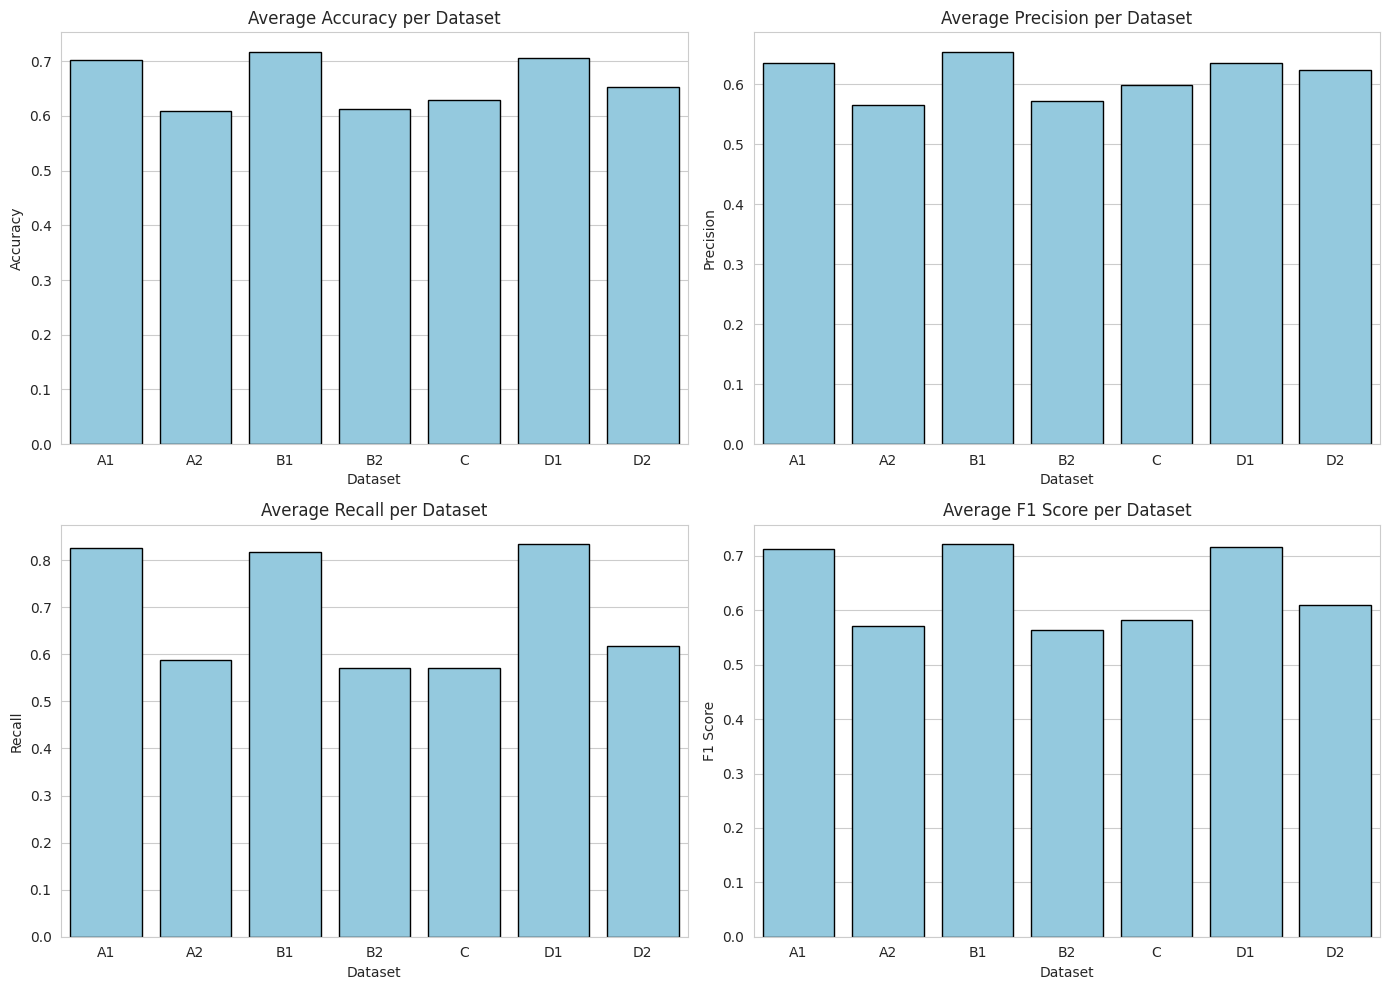

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
for i, column in enumerate(avg_per_results.columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.barplot(x=avg_per_results.index, y=avg_per_results[column], ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Average {column} per Dataset')
    ax.set_xlabel('Dataset')
    ax.set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

In [53]:
dataset_results.keys()

dict_keys(['Linear SVM', 'Polynomial SVM', 'RBF SVM', 'Sigmoid SVM', 'Logistic Regression', 'Random Forrest', 'Gradient Boost', 'KNN', 'Decision Tree', 'Bagging', 'Ada Boost', 'Navie Bayes'])

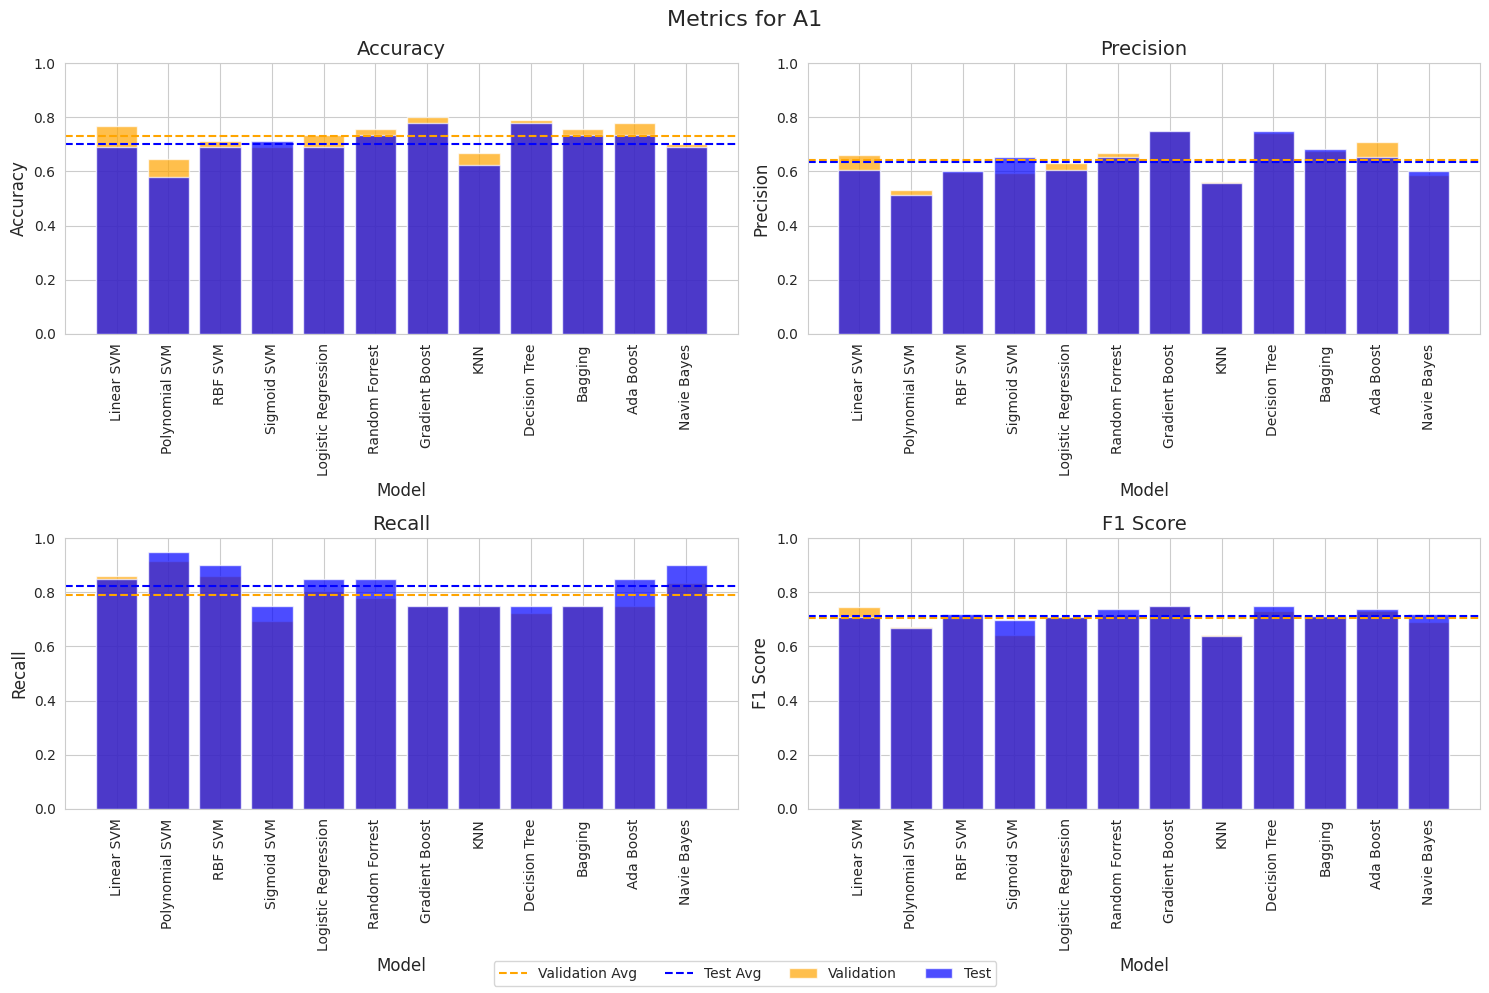

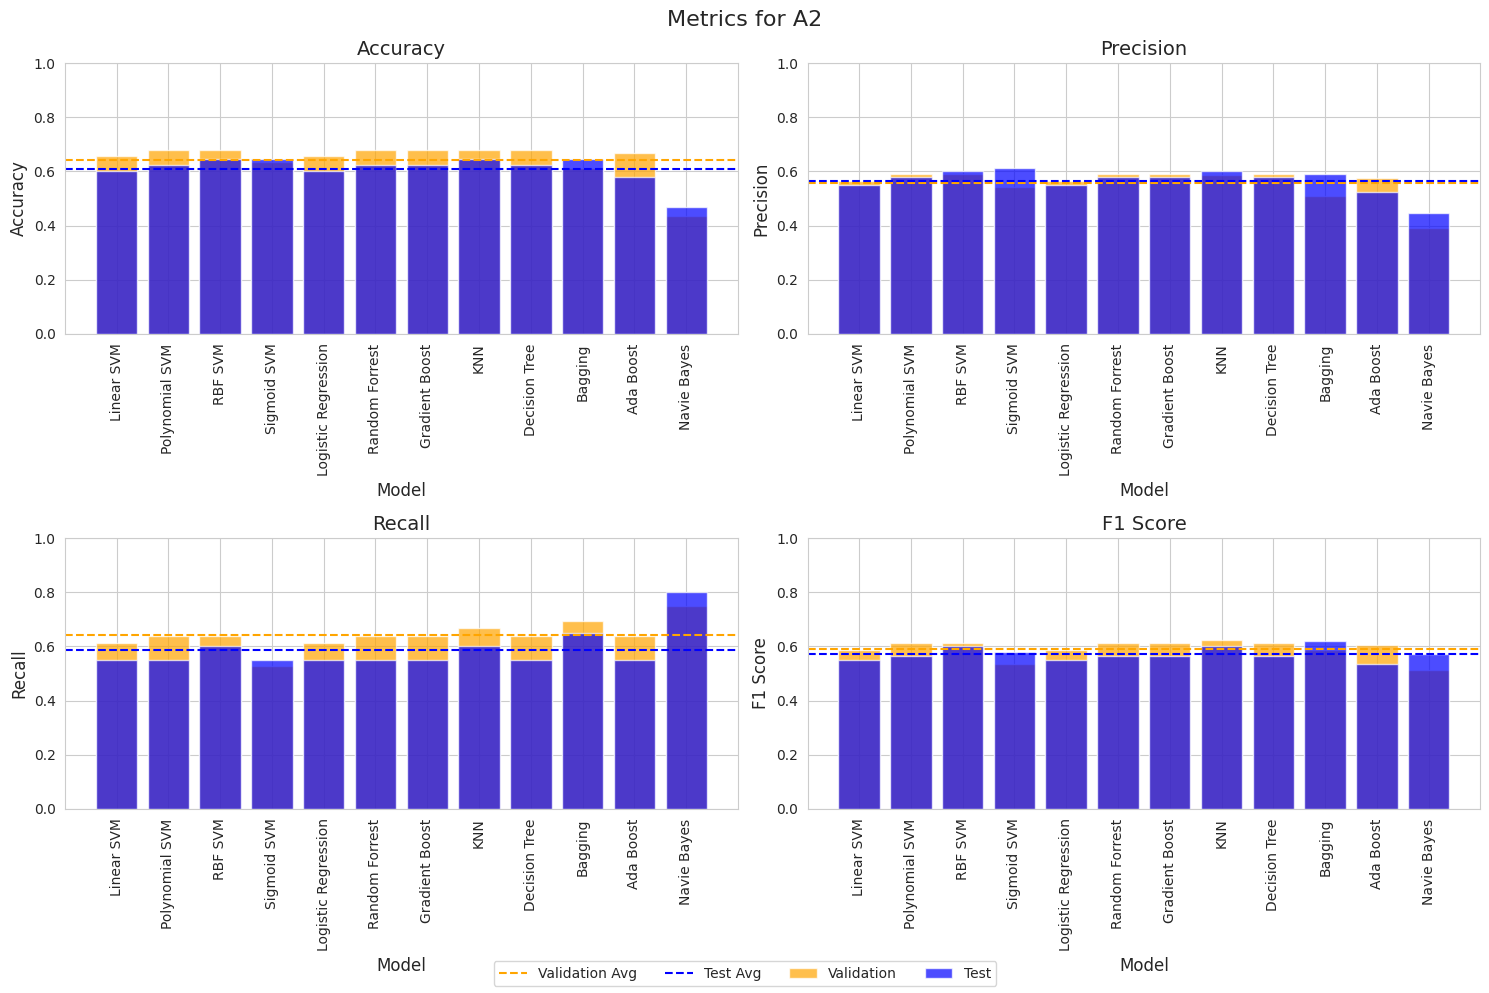

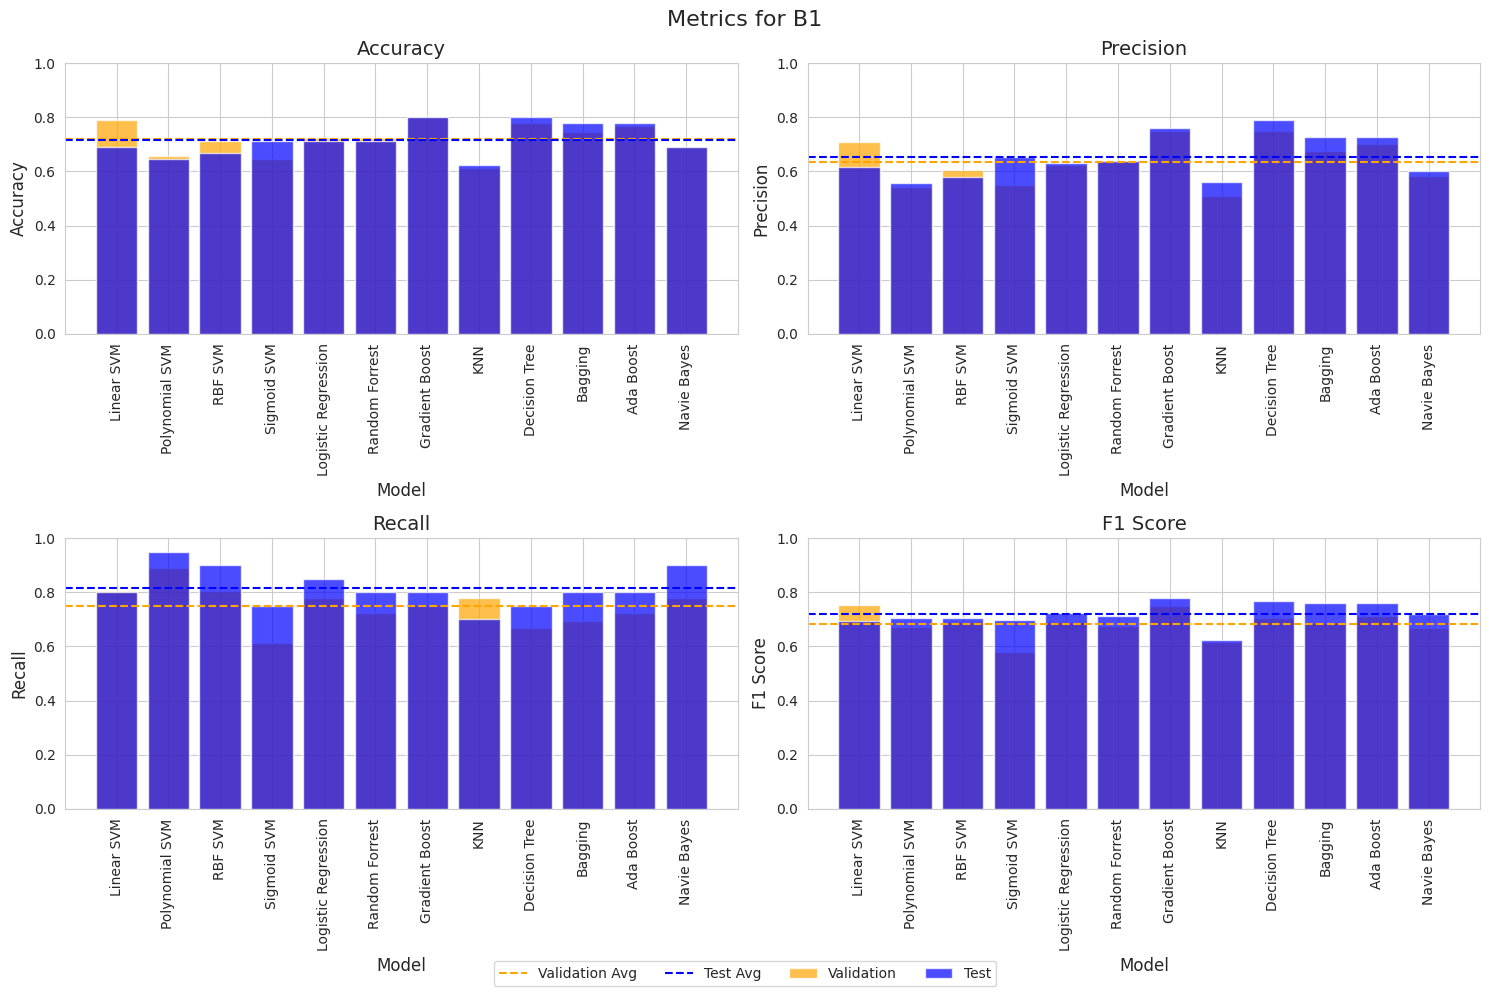

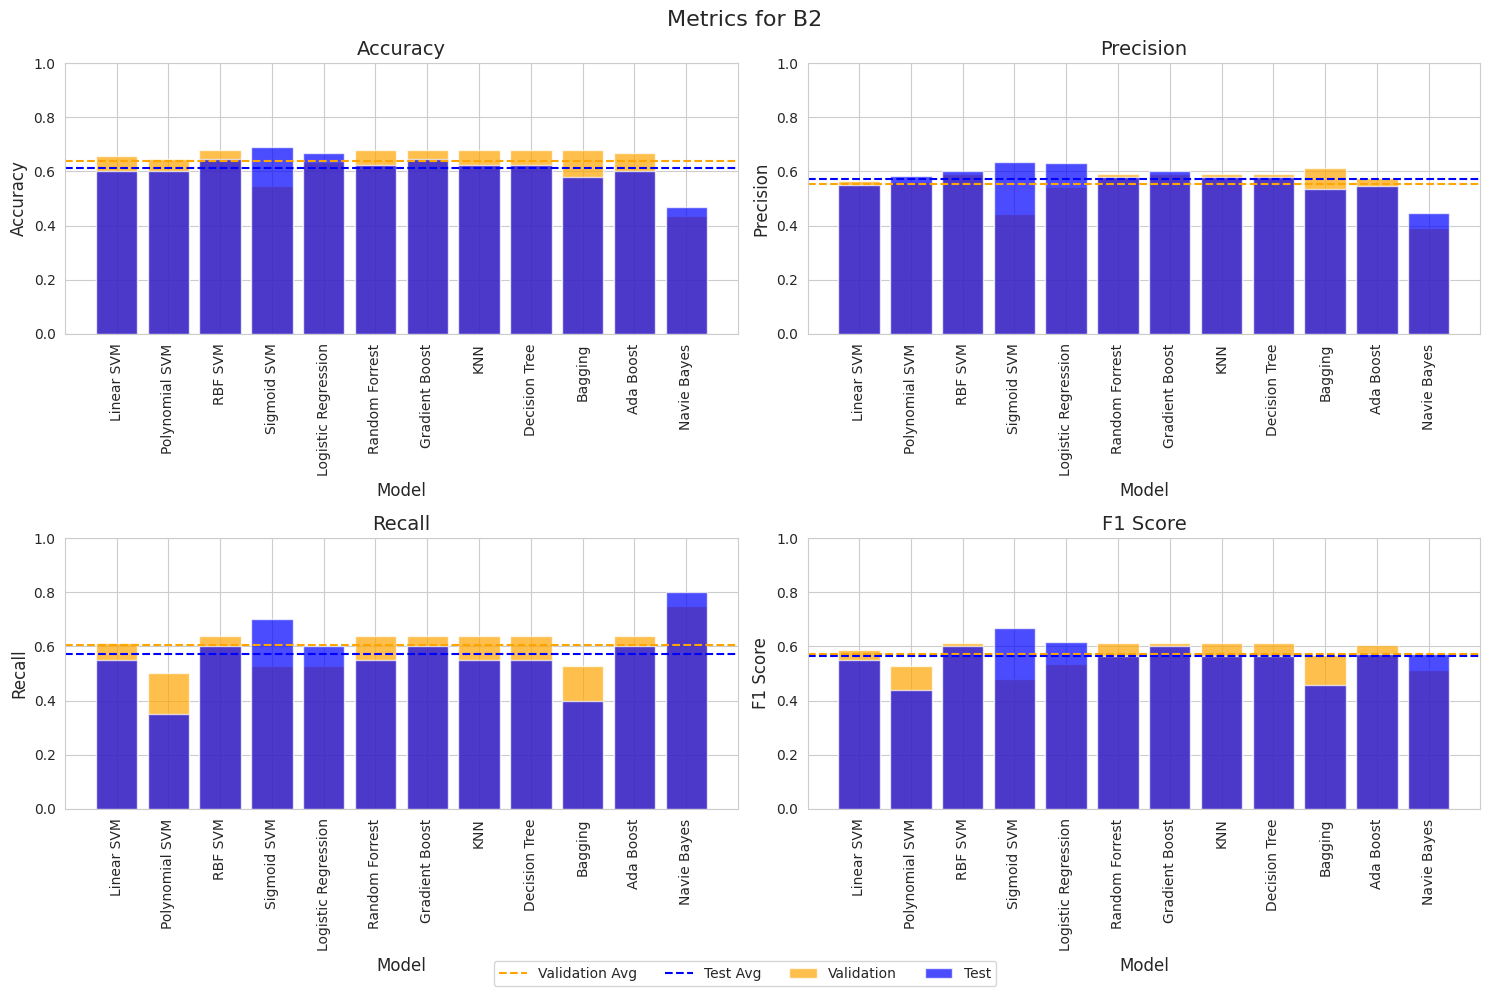

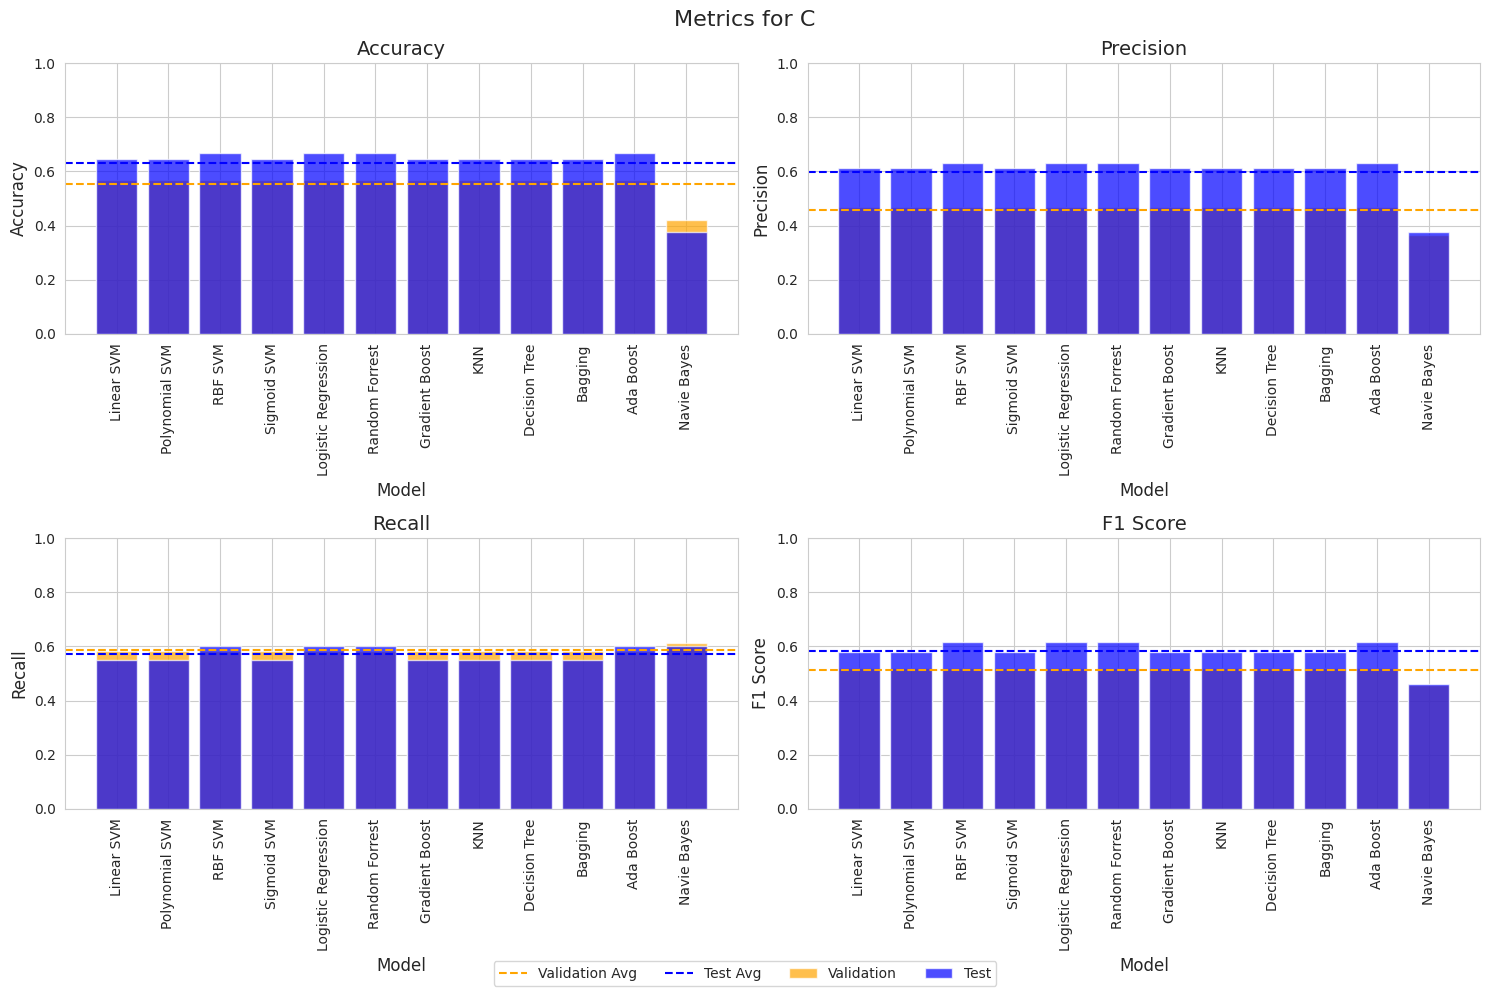

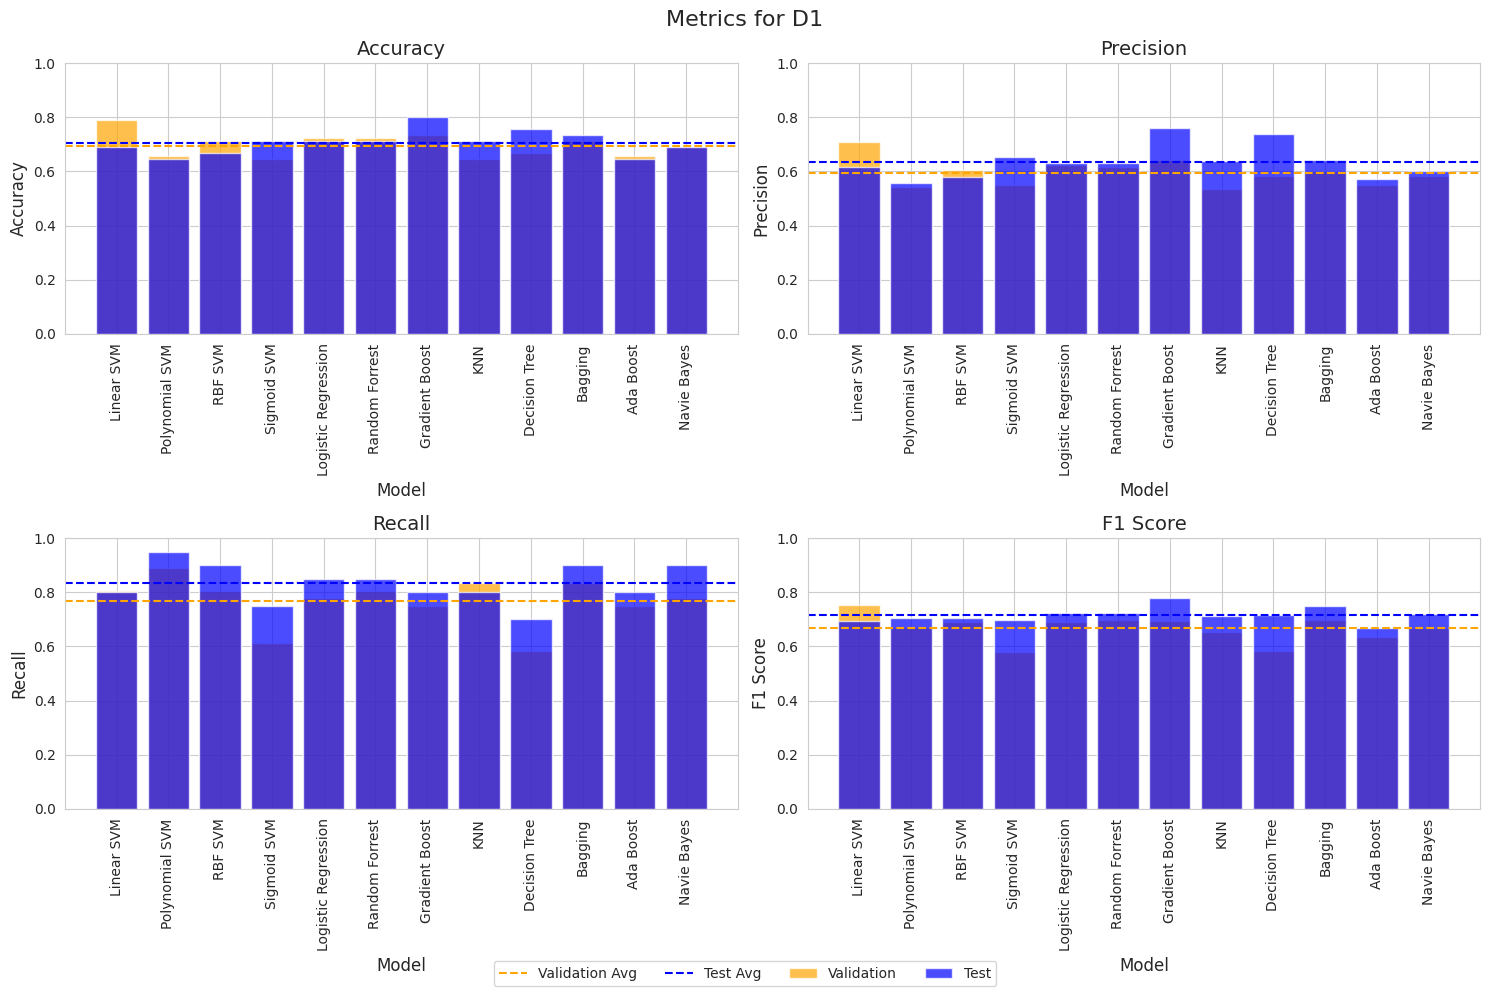

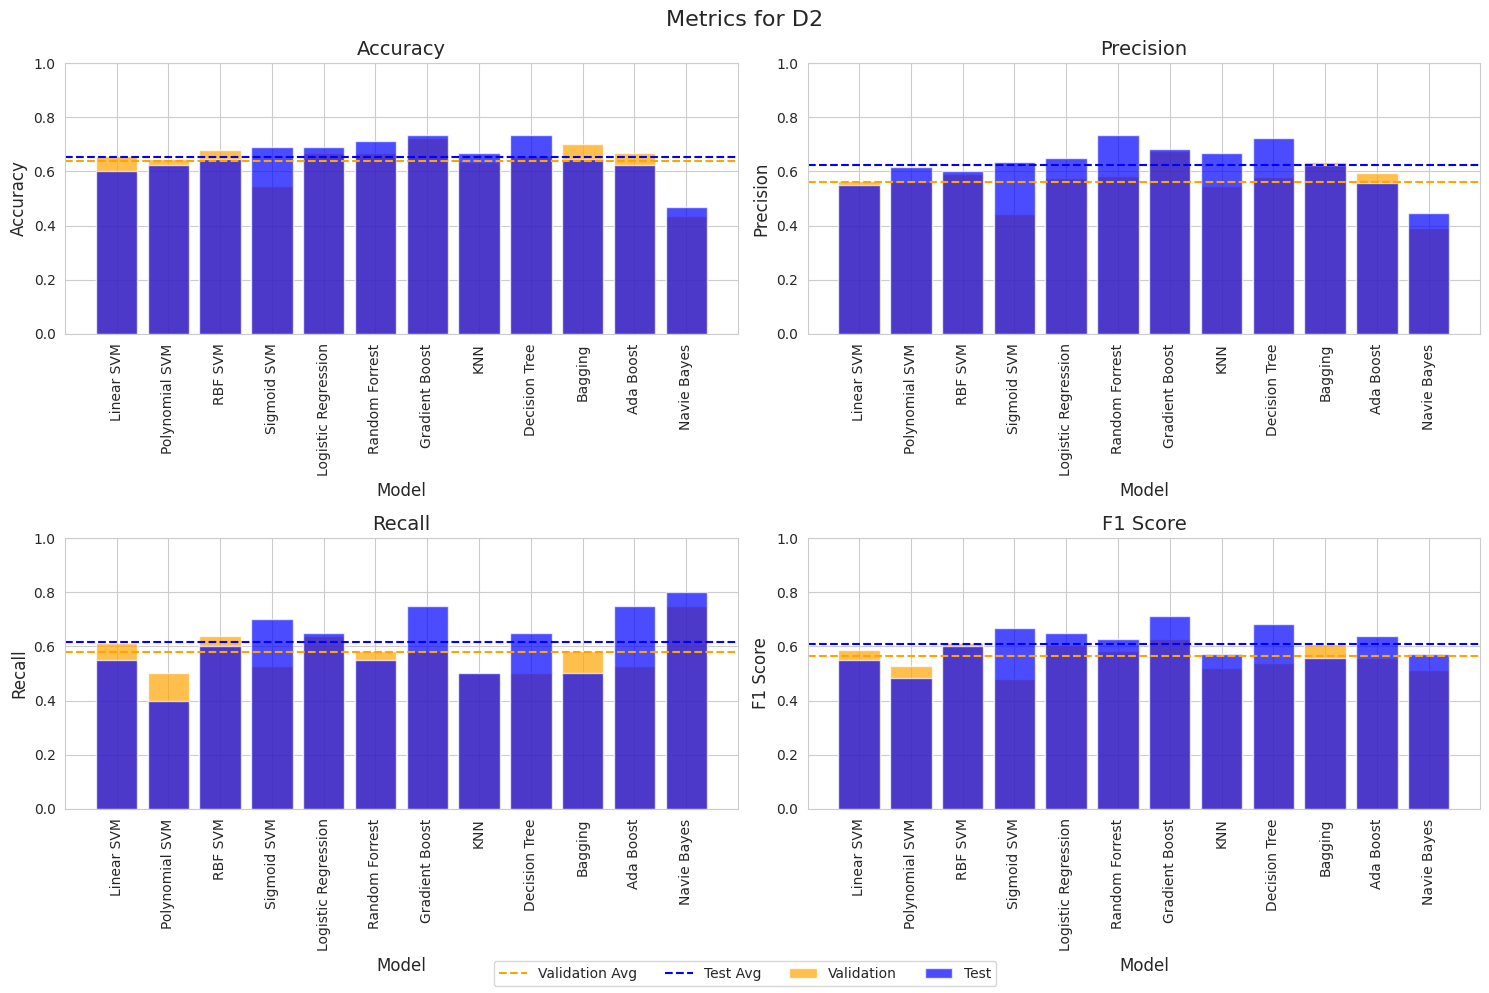

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# List of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Loop through each dataset
for dataset_name, dataset_results in results_dict.items():
    # Create subplots for each metric and split (validation and test)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Metrics for {dataset_name}', fontsize=16)

    # Flatten axs for easier indexing
    axs = axs.flatten()

    # Loop through each metric
    for i, metric in enumerate(metrics):
        # Extract metric values for validation and test splits
        val_metric_values = [model_results['Validation'][metric] for model_results in dataset_results.values()]
        test_metric_values = [model_results['Test'][metric] for model_results in dataset_results.values()]

        # Compute average values
        val_avg = np.mean(val_metric_values)
        test_avg = np.mean(test_metric_values)

        # Plot metric values for validation
        axs[i].bar(dataset_results.keys(), val_metric_values, label='Validation', color='orange' , alpha=0.7)

        # Plot metric values for test
        axs[i].bar(dataset_results.keys(), test_metric_values, label='Test', color='blue', alpha=0.7)

        # Plot average lines
        axs[i].axhline(y=val_avg, color='orange', linestyle='--', label='Validation Avg')
        axs[i].axhline(y=test_avg, color='blue', linestyle='--', label='Test Avg')
        
        axs[i].set_title(metric, fontsize=14)
        axs[i].set_ylabel(metric, fontsize=12)
        axs[i].set_xlabel('Model', fontsize=12)
        axs[i].set_ylim(0, 1)
        axs[i].tick_params(axis='x', rotation=90)

    # Add a common legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [89]:
import flaml
from flaml import AutoML
from flaml import automl

datasets = {
    "A1": XA1,
    "A2": XA2,
    "B1": XB1,
    "B2": XB2,
    "C": XC,
    "D1": XE1,
    "D2": XE2,
}

automlModel = AutoML()

results_dict = []

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    # Split the data into train, validate, and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.2, random_state=42)
    automlModel.fit(X_train,y_train,task='classification')
    y_pred = automlModel.predict(X_test)
    cm =  automl.ml.norm_confusion_matrix(y_test,y_pred)
    results_dict.append([dataset_name,automlModel,automlModel.best_estimator,automlModel.best_config,automlModel.score(X_test,y_test),cm])

results_dict

[flaml.automl.logger: 05-02 22:31:42] {1680} INFO - task = classification
[flaml.automl.logger: 05-02 22:31:42] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-02 22:31:42] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 05-02 22:31:42] {1812} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl.logger: 05-02 22:31:43] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 05-02 22:31:43] {2219} INFO - iteration 0, current learner rf
[flaml.automl.logger: 05-02 22:31:44] {2345} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 05-02 22:31:44] {2392} INFO -  at 1.3s,	estimator rf's best err

/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

[flaml.automl.logger: 05-02 22:32:12] {2628} INFO - retrain xgboost for 1.2s
[flaml.automl.logger: 05-02 22:32:12] {2631} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.9503441844594458, colsample_bynode=None,
              colsample_bytree=0.5703338448066768, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.002595066436678338,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=16651,
              min_child_weight=0.03356567864689129, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=591,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
[flaml.automl.logger: 0

/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

[flaml.automl.logger: 05-02 22:32:42] {2628} INFO - retrain xgboost for 0.6s
[flaml.automl.logger: 05-02 22:32:42] {2631} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.9503441844594458, colsample_bynode=None,
              colsample_bytree=0.5703338448066768, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.002595066436678338,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=16651,
              min_child_weight=0.03356567864689129, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=591,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
[flaml.automl.logger: 0

KeyboardInterrupt: 

In [88]:
dfList = []
for x in results_dict:
    cm = x[-1]
    accuracy = (cm.diagonal().sum() / cm.sum())
    precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    recall = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    f1_score = 2 * (precision * recall) / (precision + recall)
    dfList.append({'Dataset':x[0],'Model':x[2],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1':f1_score})

cmDf = pandas.DataFrame(dfList)
cmDf.to_csv('FLAMLresults.csv')

,Dataset,Model,Accuracy,Precision,Recall,F1
0,A1,lgbm,0.680,0.76,0.655172,0.703704
1,A2,rf,0.615,0.88,0.575163,0.695652
2,B1,extra_tree,0.765,0.88,0.715447,0.789238
3,B2,extra_tree,0.600,0.80,0.571429,0.666667
4,C,extra_tree,0.660,0.72,0.642857,0.679245
5,D1,extra_tree,0.655,0.76,0.628099,0.687783
6,D2,extra_tree,0.625,0.80,0.592593,0.680851


In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
for i, column in enumerate(cmDf.columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.barplot(x=cmDf.index, y=cmDf[column], ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Average {column} per Dataset')
    ax.set_xlabel('Model')
    ax.set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()